In [32]:
import pandas as pd  
import warnings  
warnings.filterwarnings("ignore")

In [33]:
file_name = 'data.xlsx'
df = pd.read_excel(file_name, sheet_name='1. 单维度信息', engine='openpyxl', nrows = 200, header=0 )
df2 = pd.read_excel(file_name, sheet_name='1. 单维度信息_1', engine='openpyxl', nrows = 200)
df2.columns = df.columns  
result = pd.concat([df, df2], axis=0)   
result['订单编号'] = result['订单编号'].astype(str)
result['订单编号'] = result['订单编号'].apply(lambda x : 's' + x)
PNH = result[result['城市'] == 'PNH']

# 2、配送距离分布

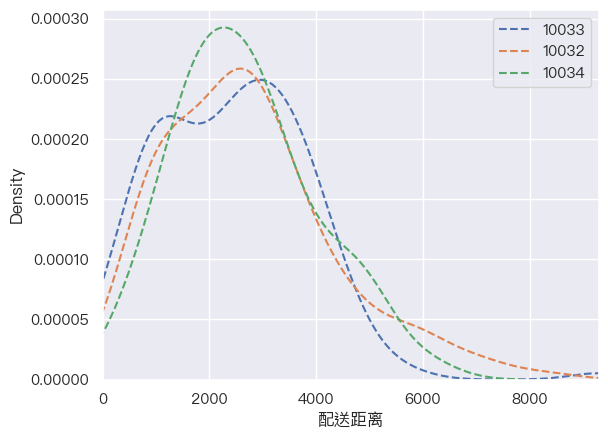

In [34]:
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib 

myfont = matplotlib.font_manager.FontProperties(fname="/System/Library/fonts/PingFang.ttc")
sns.set(font=myfont.get_name())

area_ids = PNH['站点'].unique().tolist()  

fig, ax = plt.subplots()
for area in area_ids:
    sns.kdeplot(data = PNH[ PNH['站点'] == area]['配送距离'], label = area, ax=ax, linestyle='--')
ax.legend()
plt.xlim(min(PNH['配送距离']), max(PNH['配送距离']) + 1) 
plt.show()

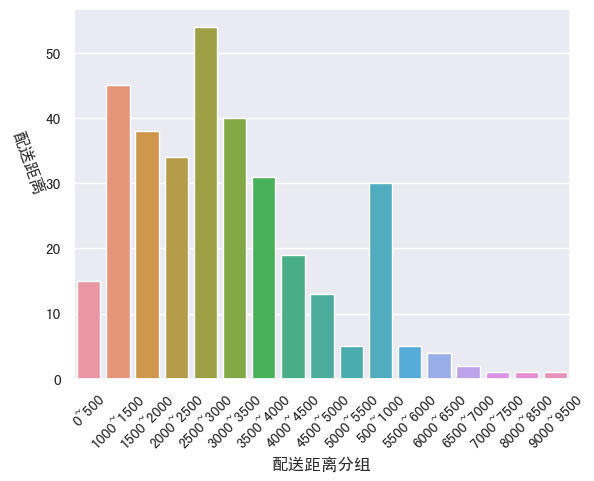

In [104]:
def convert_dist(dist, group = 500):
    dist_c = dist // group
    return str(dist_c * group) + "~" +str((dist_c+1)*group)

PNH['配送距离分组'] = PNH['配送距离'].apply(convert_dist)
group_list = sorted(PNH['配送距离分组'].unique().tolist())  
sns.countplot(x='配送距离分组', data=PNH, order=group_list)
plt.ylabel('配送距离', rotation=290, va='center', ha='right')
plt.xticks(rotation=45)
plt.show()

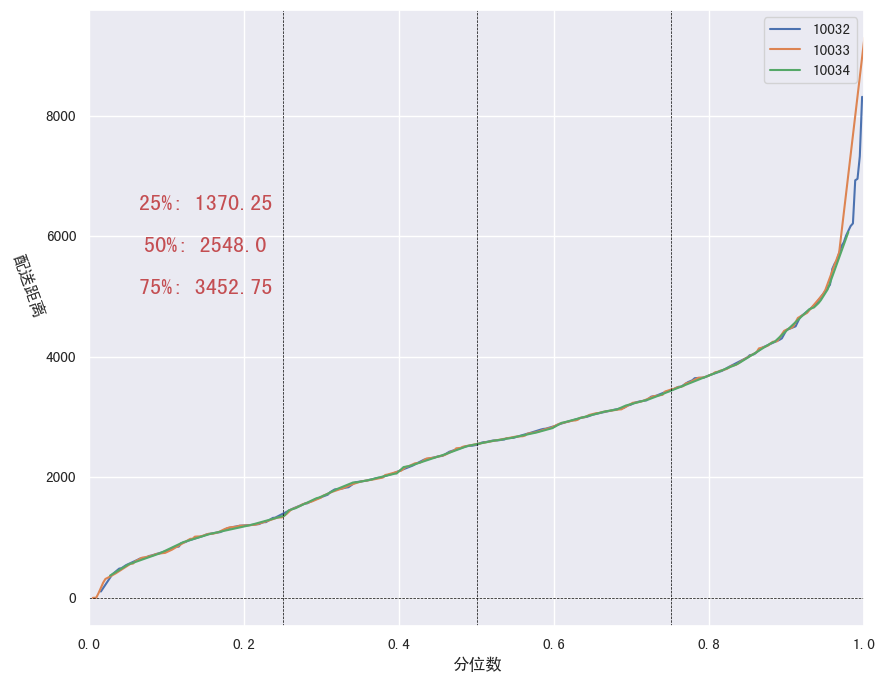

In [100]:
import matplotlib.font_manager as fm
custom_path = './SimHei.ttf'
fm.fontManager.addfont(custom_path)

q75 = np.quantile(PNH['配送距离'], 0.75)
q50 = np.quantile(PNH['配送距离'], 0.5)
q25 = np.quantile(PNH['配送距离'], 0.25)

# 计算数值列的累积分布
PNH['cumulative_percent'] = PNH['配送距离'].rank(pct=True)
# # 使用Seaborn绘制累积分布图
fig, ax = plt.subplots(figsize=(10, 8))
area_ids = sorted(area_ids)
for area in area_ids:
    sns.lineplot(x='cumulative_percent', y='配送距离', ax = ax, data = PNH[ PNH['站点'] == area], estimator=None, units=None, sort=True, label=area)
ax.legend()

plt.axvline(x=0.25, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=0.75, color='black', linestyle='--', linewidth=0.5)


plt.annotate(f"25%: {q25}\n\n50%: {q50}\n\n75%: {q75}", xy=(0.25, -0.3), xycoords='axes fraction',
             xytext=(0.15, 0.7), textcoords='axes fraction',             
             horizontalalignment='center', verticalalignment='top',  color='r', fontsize=16)

plt.annotate(f"", xy=(0.5, -0.3), xycoords='axes fraction',
             xytext=(0.4, 0.6), textcoords='axes fraction',             
             horizontalalignment='center', verticalalignment='top',  color='r', fontsize=14)

plt.annotate(f"", xy=(0.75, -0.3), xycoords='axes fraction',
             xytext=(0.65, 0.6), textcoords='axes fraction',
             horizontalalignment='center', verticalalignment='top', color='r', fontsize=14)
# # 设置x轴标签为百分比
ax.set_xlabel('分位数')
ax.set_ylabel('配送距离', rotation=290, va='center', ha='right')
ax.set_xlim(0, 1)   
ax.axhline(0, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [187]:
file_name = 'data.xlsx'
df = pd.read_excel(file_name, sheet_name='1. 单维度信息', nrows=1000, header=0)
df = df[df['城市'] == 'PNH']

# 使用 groupby 方法按站点分组，并计算每个站点的配送距离的分位数
percentiles = np.array([i * 10 for i in range(1, 11)])
quantiles = df.groupby('站点')['配送距离'].quantile(q=percentiles / 100)
quantiles_df = quantiles.unstack().rename_axis(columns='配送距离').rename_axis(index='站点')
# 把结果转化为整形
quantiles_df = quantiles_df.astype(int)
r = quantiles_df.reset_index()
r = r.rename_axis(None, axis = 1)
r.head()

,站点,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,10032,738,1206,1835,2227,2524,2853,3216,3852,4534,8311
1,10033,667,1177,1590,2034,2488,2821,3351,3871,4644,8993
2,10034,1111,1455,2112,2470,2774,3015,3278,3921,4515,9069
3,10051,3740,3740,3740,3740,3740,3740,3740,3740,3740,3740


In [282]:
def divided_by_time(df_100012, time_bin, time_col='audit_time'):
    """
    将数据按照时间间隔划分
    :param df_100012: DataFrame
    :param time_bin: int
    :return: DataFrame
    """
    df_100012.set_index(time_col, inplace=True)
    orders_count_per_10min = df_100012.resample(f'{time_bin}T').size()
    return orders_count_per_10min


def bin_plot(df, min_bin, time_col='audit_time', station_col='pharmacy_id'):
    """
    bins折线统计图, 你可以指定列名
    :param df: 订单数据
            order_id  pharmacy_id           audit_time   longitude   latitude
            635434       100012  2021-05-09 16:45:50  116.427927  39.945023
            699233       100012  2021-08-17 10:04:06  116.435130  39.913597
            724576       100012  2021-09-17 15:47:42  116.435403  39.913041
            731505       100012  2021-09-25 08:03:05  116.438485  39.935308
            735979       100012  2021-09-30 09:18:59  116.423421  39.935245
    :param min_bin:桶的大小，比如每10分钟一个桶
    :param time_col:时间列名
    :param station_col:站点列名
    :return:
    """
    df[time_col] = pd.to_datetime(df[time_col])
    stations = set(df[station_col])

    plt.figure(dpi=300, figsize=(6, 3))
    for station in stations:
        df_station = df[df[station_col] == station]
        orders_count_per_10min = divided_by_time(df_station, min_bin, time_col=time_col)
        
        orders_count_selected_date = orders_count_per_10min.groupby(
            orders_count_per_10min.index.strftime('%H:%M')).sum()
        
        full_index = pd.date_range('00:00', '23:50', freq='10T').strftime('%H:%M')
        orders_count_selected_date.reindex(full_index, fill_value=0)
        orders_count_selected_date.plot(label=station,  linestyle='--')
    plt.ylabel('orders count')
    plt.xlabel('time')
    plt.legend()
    list_r = full_index.values.tolist()  
    plt.xticks(range(0, len(orders_count_selected_date)-1, 24), list_r[::24])
    plt.tight_layout()
    plt.grid(True)
    # plt.show()

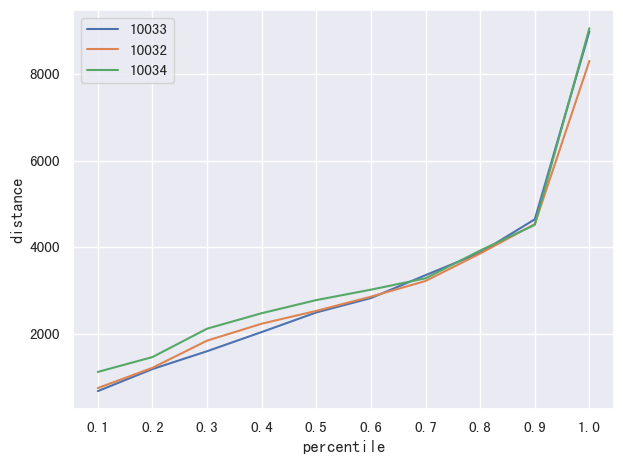

In [251]:
station_ids = PNH['站点'].unique().tolist()  
for station_id in station_ids:
    plt.plot(r[r['站点'] == station_id].iloc[:, 1:].values[0], label=station_id)
plt.legend()
plt.xlabel('percentile')
plt.ylabel('distance')
plt.xticks(range(10), percentiles/100)
plt.tight_layout()
plt.grid(True)    
plt.show()

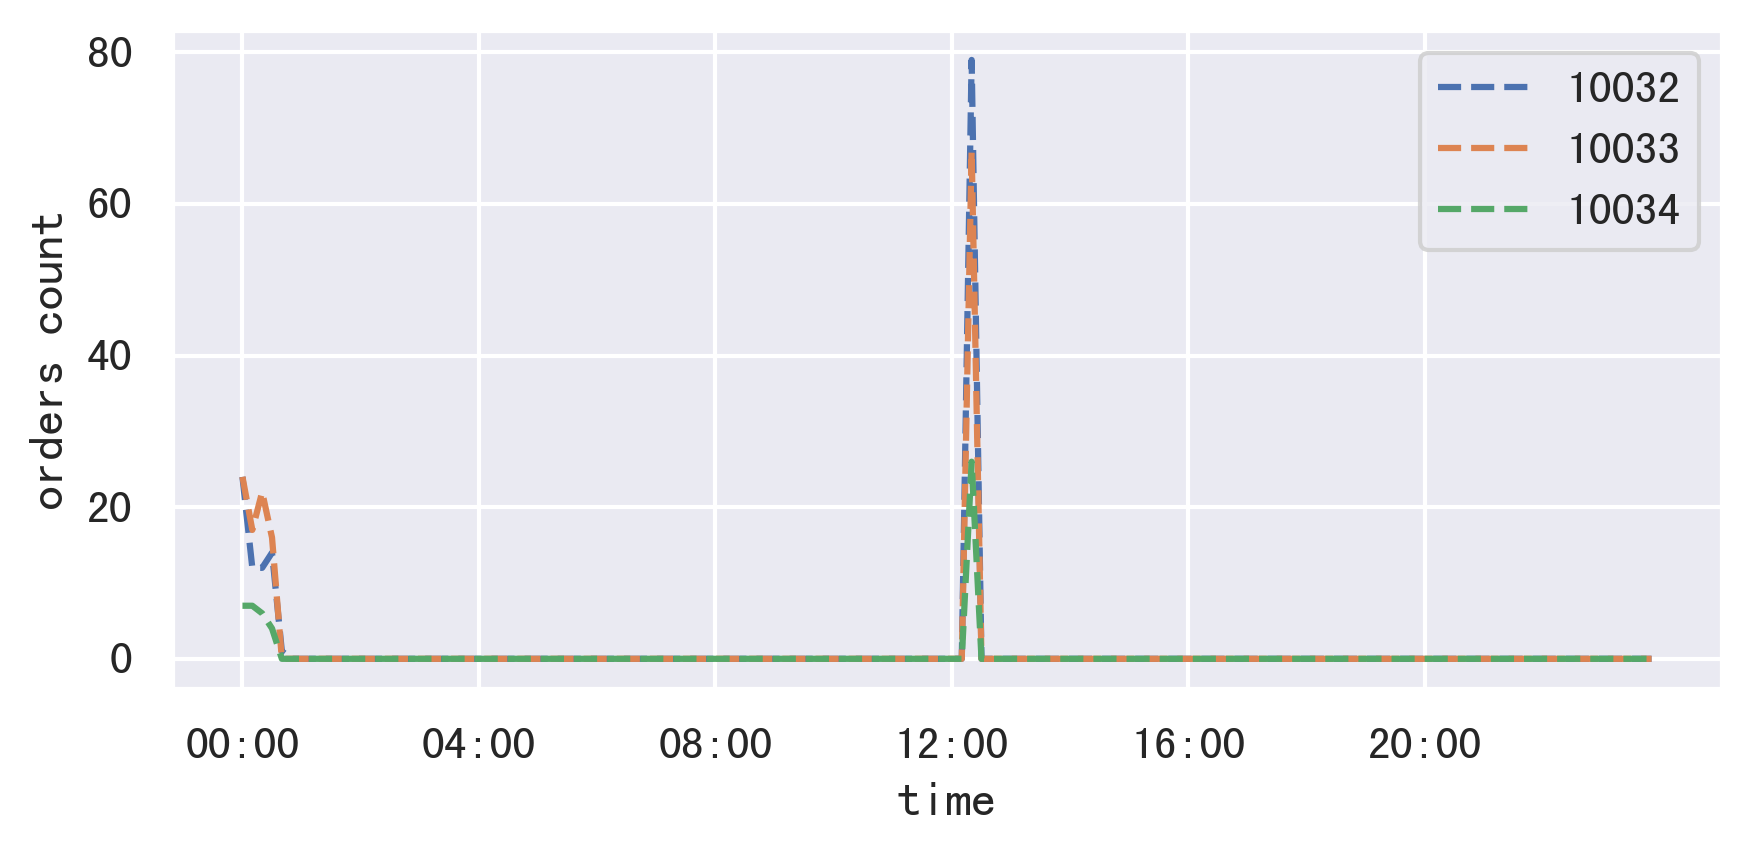

In [283]:
file_name = 'data.xlsx'
df = pd.read_excel(file_name, sheet_name='1. 单维度信息', engine='openpyxl', nrows = 200, header=0 )
df2 = pd.read_excel(file_name, sheet_name='1. 单维度信息_1', engine='openpyxl', nrows = 200)
df2.columns = df.columns  
result = pd.concat([df, df2], axis=0)   
result['订单编号'] = result['订单编号'].astype(str)
result['订单编号'] = result['订单编号'].apply(lambda x : 's' + x)
PNH = result[result['城市'] == 'PNH']

# 桶的图
bin_plot(PNH, 10, time_col='下单时间', station_col='站点')
#plt.show()

# 0、基础数据清洗

In [120]:
import pandas as pd  
import warnings  

warnings.filterwarnings("ignore")
df1 = pd.read_excel('data/1.xlsx', engine='openpyxl')
df2 = pd.read_excel('data/2.xlsx', engine='openpyxl')
df2.columns = df1.columns  
data = pd.concat([df1, df2], axis=0)

time_cols = [col for col in data.columns if '时间' in col]
for col in time_cols:
    data[col] = pd.to_datetime(data[col])
    data[col] = data[col].dt.strftime('%m-%d %H:%M:%S')

# 定义正则表达式模式，匹配并提取A和B
pattern = r'(\w+):(\w+)'
data[['小时', '分钟']] = data['下单时间'].str.extract(pattern)
data['小时'] = pd.to_numeric(data['小时'], errors='coerce')
data['分钟'] = pd.to_numeric(data['分钟'], errors='coerce')
data['分钟桶'] = data['小时'] * 60 + data['分钟']
data['日期'] = data['下单时间'].astype(str)
data['日期'] = data['日期'].apply(lambda x : x.split(" ")[0])


#制作餐厅基础数据
use_cols = ['餐厅编号', '餐厅经度', '餐厅纬度']
resturuant = data[use_cols].drop_duplicates(subset=use_cols)
resturuant.to_csv('./data/resturuant.csv', encoding='utf-8', index = False)

#读取餐厅的编号
resturuant = pd.read_csv('./data/resturuant.csv')
resturuant = resturuant.reset_index()
resturuant.rename(columns={'index': '简化编号'}, inplace=True)
resturuant_map = resturuant.set_index('餐厅编号')['简化编号'].to_dict()

data['简化餐厅编号'] = data['餐厅编号'].map(resturuant_map)
data.drop(columns=['餐厅编号', '餐厅经度', '餐厅纬度'], inplace=True)
data.to_csv('./data/data_clean.csv', index = False)


#按城市保存数据
data_clean = pd.read_csv('./data/data_clean.csv')
for city_id in set(data_clean['城市']):
    data_clean_city = data_clean[data_clean['城市'] == city_id]
    data_clean_city.to_csv(f"./data/{city_id}.csv", index = False)

# 1、餐厅出餐密集度

In [85]:
counts = PNH['简化餐厅编号'].value_counts().sort_values(ascending=False)
percentages = counts / counts.sum() * 100
percentages_str = percentages.map("{:.2f}%".format)
result = pd.DataFrame({'餐厅编号': counts.index,
                       '数量': counts.values,
                       '百分比': percentages_str})
result.head()

,餐厅编号,数量,百分比
770,770,16885,1.37%
6453,6453,10407,0.85%
6,6,9368,0.76%
543,543,9007,0.73%
341,341,8635,0.70%


# 2、配送距离分布

In [129]:
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib 
import numpy as np

myfont = matplotlib.font_manager.FontProperties(fname="/System/Library/fonts/PingFang.ttc")
sns.set(font=myfont.get_name())

# 使用 groupby 方法按站点分组，并计算每个站点的配送距离的分位数
percentiles = np.array([i * 10 for i in range(1, 11)])
quantiles = PNH.groupby('站点')['配送距离'].quantile(q=percentiles / 100)
quantiles_df = quantiles.unstack().rename_axis(columns='配送距离').rename_axis(index='站点')
# 把结果转化为整形
quantiles_df = quantiles_df.astype(int)
r = quantiles_df.reset_index()
r = r.rename_axis(None, axis = 1)
r.head()

,站点,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,10032,677,1115,1531,1928,2323,2731,3165,3652,4295,21509
1,10033,725,1152,1559,1939,2307,2697,3132,3639,4338,21973
2,10034,843,1348,1790,2163,2549,2948,3369,3857,4509,23026
3,10051,0,1210,1895,2385,2882,3402,3847,4572,5793,23366
4,10054,13248,13248,13248,13248,13248,13248,13248,13248,13248,13248


In [130]:
def divided_by_time(df_100012, time_bin, time_col='audit_time'):
    """
    将数据按照时间间隔划分
    :param df_100012: DataFrame
    :param time_bin: int
    :return: DataFrame
    """
    df_100012.set_index(time_col, inplace=True)
    orders_count_per_10min = df_100012.resample(f'{time_bin}T').size()
    return orders_count_per_10min


def bin_plot(df, min_bin, time_col='audit_time', station_col='pharmacy_id'):
    """
    bins折线统计图, 你可以指定列名
    :param df: 订单数据
            order_id  pharmacy_id           audit_time   longitude   latitude
            635434       100012  2021-05-09 16:45:50  116.427927  39.945023
            699233       100012  2021-08-17 10:04:06  116.435130  39.913597
            724576       100012  2021-09-17 15:47:42  116.435403  39.913041
            731505       100012  2021-09-25 08:03:05  116.438485  39.935308
            735979       100012  2021-09-30 09:18:59  116.423421  39.935245
    :param min_bin:桶的大小，比如每10分钟一个桶
    :param time_col:时间列名
    :param station_col:站点列名
    :return:
    """
    df[time_col] = pd.to_datetime(df[time_col])
    stations = set(df[station_col])

    plt.figure(dpi=300, figsize=(6, 3))
    for station in stations:
        df_station = df[df[station_col] == station]
        orders_count_per_10min = divided_by_time(df_station, min_bin, time_col=time_col)
        
        orders_count_selected_date = orders_count_per_10min.groupby(
            orders_count_per_10min.index.strftime('%H:%M')).sum()
        
        full_index = pd.date_range('00:00', '23:50', freq='10T').strftime('%H:%M')
        orders_count_selected_date.reindex(full_index, fill_value=0)
        orders_count_selected_date.plot(label=station,  linestyle='--')
    plt.ylabel('orders count')
    plt.xlabel('time')
    plt.legend()
    list_r = full_index.values.tolist()  
    plt.xticks(range(0, len(orders_count_selected_date)-1, 24), list_r[::24])
    plt.tight_layout()
    plt.grid(True)
    # plt.show()

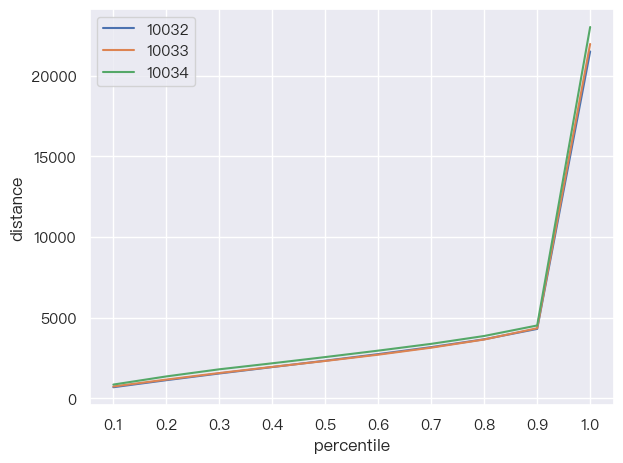

In [133]:
station_ids = [10032, 10033, 10034]
for station_id in station_ids:
    plt.plot(r[r['站点'] == station_id].iloc[:, 1:].values[0], label=station_id)
plt.legend()
plt.xlabel('percentile')
plt.ylabel('distance')
plt.xticks(range(10), percentiles/100)
plt.tight_layout()
plt.grid(True)    
plt.show()

In [189]:
import pandas as pd

df = PNH
import pandas as pd
bins = range(0, 10001, 1000)
labels = [f'0-{i+1000}' for i in bins[:-1]] 
df['score_group'] = pd.cut(df['配送距离'], bins=bins, labels=labels, include_lowest=True)
grouped_counts = df.groupby(['站点', 'score_group']).size().unstack(fill_value=0)
pivot_counts = df.groupby(['站点', 'score_group']).size().unstack(fill_value=0)
pivot_pct = pivot_counts.div(pivot_counts.sum(axis=1), axis=0) * 100
pivot_pct = pivot_pct.round(2)
r = pivot_pct.reset_index()
r = r.rename_axis(None, axis = 1)
df = r
df = df.T
df.iloc[1:] = np.cumsum(df.iloc[1:], axis=0)
df = df.T
last_column_name = df.columns[-1]
df[last_column_name] = 100.00
df['站点'] = df['站点'].astype(int)

PNH_dist_group = PNH.groupby('站点')['配送距离'].count().reset_index()
PNH_dist_group = PNH_dist_group.rename(columns={'配送距离': '单量'})
PNH_dist_group = df.merge(PNH_dist_group)
PNH_dist_group.head()

,站点,0-1000,0-2000,0-3000,0-4000,0-5000,0-6000,0-7000,0-8000,0-9000,0-10000,单量
0,10032,17.51,41.90,66.35,85.91,95.88,98.14,99.28,99.75,99.91,100.0,539641
1,10033,16.39,41.68,67.17,85.88,95.14,97.55,98.93,99.56,99.84,100.0,490408
2,10034,13.11,35.42,61.49,82.74,94.34,97.27,98.84,99.48,99.78,100.0,192043
3,10051,17.74,33.20,52.82,72.51,86.87,92.13,94.99,96.81,98.76,100.0,1561
4,10054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,1


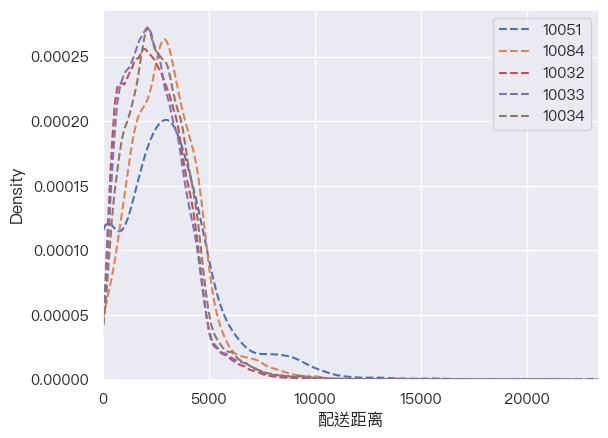

In [190]:
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib 

myfont = matplotlib.font_manager.FontProperties(fname="/System/Library/fonts/PingFang.ttc")
sns.set(font=myfont.get_name())

area_ids = set(PNH['站点'].unique())

fig, ax = plt.subplots()
for area in area_ids:
    sns.kdeplot(data = PNH[ PNH['站点'] == area]['配送距离'], label = area, ax=ax, linestyle='--')
ax.legend()
plt.xlim(min(PNH['配送距离']), max(PNH['配送距离']) + 1) 
plt.show()

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib 
import numpy as np
import pandas as pd

myfont = matplotlib.font_manager.FontProperties(fname="/System/Library/fonts/PingFang.ttc")
sns.set(font=myfont.get_name())

df = pd.read_excel('./data/PNH_3.1-3.7.xlsx')

Index(['城市', '站点', '订单编号', '下单时间', '配送距离', '用户收货经度', '用户收货纬度', '许诺用户送达时间',
       '订单取消时间', '小时', '分钟', '分钟桶', '日期', '简化餐厅编号'],
      dtype='object')


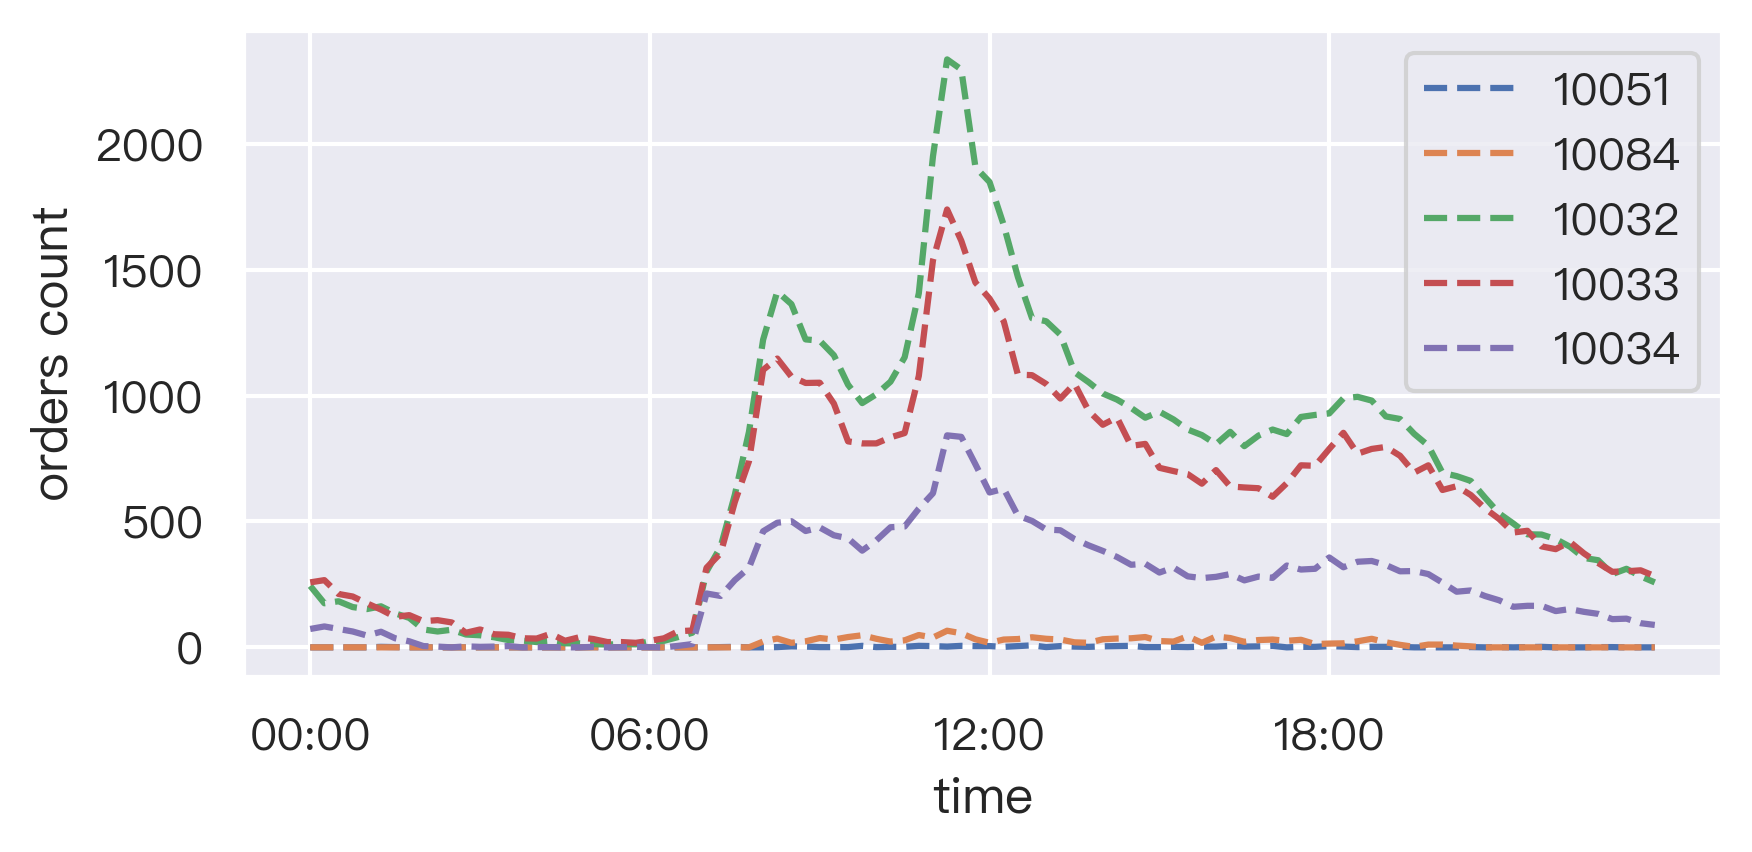

In [68]:
def divided_by_time(df_100012, time_bin, time_col='audit_time'):
    """
    将数据按照时间间隔划分
    :param df_100012: DataFrame
    :param time_bin: int
    :return: DataFrame
    """
    df_100012.set_index(time_col, inplace=True)
    orders_count_per_10min = df_100012.resample(f'{time_bin}T').size()
    return orders_count_per_10min


def bin_plot(df, min_bin, time_col='audit_time', station_col='pharmacy_id'):
    """
    bins折线统计图, 你可以指定列名
    :param df: 订单数据
            order_id  pharmacy_id           audit_time   longitude   latitude
            635434       100012  2021-05-09 16:45:50  116.427927  39.945023
            699233       100012  2021-08-17 10:04:06  116.435130  39.913597
            724576       100012  2021-09-17 15:47:42  116.435403  39.913041
            731505       100012  2021-09-25 08:03:05  116.438485  39.935308
            735979       100012  2021-09-30 09:18:59  116.423421  39.935245
    :param min_bin:桶的大小，比如每10分钟一个桶
    :param time_col:时间列名
    :param station_col:站点列名
    :return:
    """
   
    print(df.columns)
    df[time_col] = pd.to_datetime(df[time_col])
    stations = set(df[station_col])

    plt.figure(dpi=300, figsize=(6, 3))
    for station in stations:
        df_station = df[df[station_col] == station]
        orders_count_per_10min = divided_by_time(df_station, min_bin, time_col=time_col)
        
        orders_count_selected_date = orders_count_per_10min.groupby(
            orders_count_per_10min.index.strftime('%H:%M')).sum()
        
        full_index = pd.date_range('00:00', '23:45', freq='15T').strftime('%H:%M')
        orders_count_selected_date.reindex(full_index, fill_value=0)
        orders_count_selected_date.plot(label=station,  linestyle='--')
    plt.ylabel('orders count')
    plt.xlabel('time')
    plt.legend()
    list_r = full_index.values.tolist()  
    plt.xticks(range(0, len(orders_count_selected_date)-1, 24), list_r[::24])
    plt.tight_layout()
    plt.grid(True)
    # plt.show()
    
bin_plot(df, 15, time_col='下单时间', station_col='站点')

In [69]:
# 计算时间差
df['总时长'] = df['许诺用户送达时间'] - df['下单时间']
# 如果你想要得到时间差的具体天数，可以使用 .dt.days
df['送达-下单'] = df['总时长'].dt.seconds
df.head()

,城市,站点,订单编号,下单时间,配送距离,用户收货经度,用户收货纬度,许诺用户送达时间,订单取消时间,小时,分钟,分钟桶,日期,简化餐厅编号,总时长,送达-下单
0,PNH,10033,1763247956585110016,2024-03-01 00:00:47,3261,104.904887,11.532218,2024-03-01 00:40:47,NaT,0,0,0,45352,0,0 days 00:40:00,2400
1,PNH,10032,1763247981091879936,2024-03-01 00:00:53,2925,104.887330,11.584183,2024-03-01 00:55:53,NaT,0,0,0,45352,1,0 days 00:55:00,3300
2,PNH,10032,1763248058112430080,2024-03-01 00:01:11,105,104.907842,11.565030,2024-03-01 00:39:28,NaT,0,1,1,45352,2,0 days 00:38:17,2297
3,PNH,10034,1763248162121910016,2024-03-01 00:01:36,2816,104.829285,11.548750,2024-03-01 00:41:36,NaT,0,1,1,45352,3,0 days 00:40:00,2400
4,PNH,10033,1763248178274500096,2024-03-01 00:01:40,4170,104.932748,11.544754,2024-03-01 08:00:00,NaT,0,1,1,45352,4,0 days 07:58:20,28700


# 预计送达时间 分桶

In [70]:
import warnings  
warnings.filterwarnings("ignore")

bins = range(0, 5400+1, 600)
labels = [f'{i}-{i+600}' for i in bins[:-1]] 
df_time_diff = df[df['送达-下单'] <= 5400]
df_time_diff['时间差分桶'] = pd.cut(df_time_diff['送达-下单'], bins=bins, labels=labels, include_lowest=True)
grouped_counts = df_time_diff.groupby(['站点', '时间差分桶']).size().unstack(fill_value=0)
pivot_pct = grouped_counts.div(grouped_counts.sum(axis=1), axis=0) * 100
pivot_pct = pivot_pct.round(2)
r = pivot_pct.reset_index()
r = r.rename_axis(None, axis = 1)
r

,站点,0-600,600-1200,1200-1800,1800-2400,2400-3000,3000-3600,3600-4200,4200-4800,4800-5400
0,10032,0.0,0.0,11.36,35.12,29.17,16.15,5.75,1.74,0.71
1,10033,0.0,0.0,10.49,35.12,28.51,14.93,6.65,2.73,1.57
2,10034,0.0,0.0,7.05,33.15,31.51,17.05,7.86,2.33,1.05
3,10051,0.0,0.0,6.15,20.00,20.00,13.08,16.15,16.15,8.46
4,10084,0.0,0.0,0.35,0.35,1.30,8.99,25.58,32.41,31.03


In [71]:
df_cu_time = r
df_cu_time = df_cu_time.T
df_cu_time.iloc[1:] = np.cumsum(df_cu_time.iloc[1:], axis=0)
df_cu_time = df_cu_time.T
last_column_name = df_cu_time.columns[-1]
df_cu_time[last_column_name] = 100.00
df_cu_time['站点'] = df_cu_time['站点'].astype(int)
df_cu_time.head()

,站点,0-600,600-1200,1200-1800,1800-2400,2400-3000,3000-3600,3600-4200,4200-4800,4800-5400
0,10032,0.0,0.0,11.36,46.48,75.65,91.80,97.55,99.29,100.0
1,10033,0.0,0.0,10.49,45.61,74.12,89.05,95.70,98.43,100.0
2,10034,0.0,0.0,7.05,40.20,71.71,88.76,96.62,98.95,100.0
3,10051,0.0,0.0,6.15,26.15,46.15,59.23,75.38,91.53,100.0
4,10084,0.0,0.0,0.35,0.70,2.00,10.99,36.57,68.98,100.0


In [86]:
correlation = df['送达-下单'].corr(df['配送距离'])
correlation = round(correlation, 4) 
print(f"送达-下单(时长) and 配送距离 相关性: {correlation:.3f}")

送达-下单(时长) and 配送距离 相关性: 0.341


In [87]:
df.head()

,城市,站点,订单编号,下单时间,配送距离,用户收货经度,用户收货纬度,许诺用户送达时间,订单取消时间,小时,分钟,分钟桶,日期,简化餐厅编号,总时长,送达-下单
0,PNH,10033,1763247956585110016,2024-03-01 00:00:47,3261,104.904887,11.532218,2024-03-01 00:40:47,NaT,0,0,0,45352,0,0 days 00:40:00,2400
1,PNH,10032,1763247981091879936,2024-03-01 00:00:53,2925,104.887330,11.584183,2024-03-01 00:55:53,NaT,0,0,0,45352,1,0 days 00:55:00,3300
2,PNH,10032,1763248058112430080,2024-03-01 00:01:11,105,104.907842,11.565030,2024-03-01 00:39:28,NaT,0,1,1,45352,2,0 days 00:38:17,2297
3,PNH,10034,1763248162121910016,2024-03-01 00:01:36,2816,104.829285,11.548750,2024-03-01 00:41:36,NaT,0,1,1,45352,3,0 days 00:40:00,2400
4,PNH,10033,1763248178274500096,2024-03-01 00:01:40,4170,104.932748,11.544754,2024-03-01 08:00:00,NaT,0,1,1,45352,4,0 days 07:58:20,28700


In [96]:
# 按班级分组计算平均分数
average_scores = df.groupby('简化餐厅编号')['配送距离'].mean()
average_scores_2 = df.groupby('简化餐厅编号')['配送距离'].max()
wb_counts = df.groupby('简化餐厅编号').size()

# 将学生人数和平均分数合并到一个新的DataFrame中
result = pd.DataFrame({
    '简化餐厅编号': wb_counts.index,
    '订单数量': wb_counts.values,
    '平均配送距离': average_scores.values,
    '最大配送距离':average_scores_2.values
})

result = result.sort_values(by='平均配送距离', ascending=False)
result.head()


,简化餐厅编号,订单数量,平均配送距离,最大配送距离
4352,5715,1,8891.0,8891
4610,6060,2,8273.5,9224
5026,7159,1,8243.0,8243
4867,6410,1,7934.0,7934
1992,2499,1,7792.0,7792


In [97]:
result.to_csv('./data/rid_wbCnt_avgdist_maxdist.csv', encoding='utf-8', index = False)

In [255]:
df = pd.read_excel('./data/PNH_3.1-3.7.xlsx')

In [256]:
total_orders_by_city = df.groupby(['站点','简化餐厅编号'])['订单编号'].count().reset_index()
total_orders_by_city.head()

,站点,简化餐厅编号,订单编号
0,10032,0,15
1,10032,1,167
2,10032,2,62
3,10032,3,1
4,10032,4,141


In [146]:
import pandas as pd
import numpy as np

# 假设df是你的DataFrame，包含'Order_ID', 'City_ID', 'Restaurant_ID'三列
# 加载数据的代码应该在此处，但这里我们直接假设df已经存在

# 计算每个城市的订单总数
orders_per_city = df.groupby('站点')['订单编号'].nunique()

# 计算每个城市每个餐厅的订单量
restaurant_orders = df.groupby(['站点', '简化餐厅编号']).size().reset_index(name='Order_Count')

# 初始化结果存储DataFrame
percentiles = np.arange(10, 101, 10)  # 定义百分比列表
result = pd.DataFrame(columns=['City_ID', 'Percentage', 'Top_Restaurant_Count'])

# 遍历每个城市
for city_id, total_orders in orders_per_city.items():
    # 获取当前城市的餐厅订单统计数据
    city_restaurant_orders = restaurant_orders[restaurant_orders['站点'] == city_id]
    
    for percentage in percentiles:
        # 计算当前百分比的订单数量目标
        target_orders = total_orders * (percentage / 100)
        
        # 对餐厅订单量进行排序并累加，直到达到或超过目标订单量
        cumulative_orders = city_restaurant_orders['Order_Count'].cumsum()
        top_restaurant_count = (cumulative_orders <= target_orders).sum()
        
        # 保存结果
        result = result.append({'City_ID': city_id, 'Percentage': percentage, 'Top_Restaurant_Count': top_restaurant_count}, ignore_index=True)

In [174]:
import pandas as pd
import numpy as np

# 假设df是你的DataFrame，包含'Order_ID', 'City_ID', 'Restaurant_ID'三列
# 加载数据的代码应该在此处，但这里我们直接假设df已经存在

# 计算每个城市的订单总数
orders_per_city = df.groupby('站点')['订单编号'].nunique()

# 计算每个城市每个餐厅的订单量
restaurant_orders = df.groupby(['站点', '简化餐厅编号']).size().reset_index(name='Order_Count')

# 定义百分比列表
percentiles = np.arange(10, 101, 10)

# 初始化结果存储字典
results = []

# 遍历每个城市
for city_id, total_orders in orders_per_city.items():
    # 获取当前城市的餐厅订单统计数据
    city_restaurant_orders = restaurant_orders[restaurant_orders['站点'] == city_id]
    
    # 对每个百分比计算头部餐厅数量
    percentile_counts = {f'{p}%': 0 for p in percentiles}
    cumulative_orders = city_restaurant_orders['Order_Count'].cumsum()
    
    for percentage in percentiles:
        target_orders = total_orders * (percentage / 100)
        percentile_counts[f'{percentage}%'] = (cumulative_orders <= target_orders).sum()
    
    # 将结果整合成一行并添加到结果列表
    results.append({**{'City_ID': city_id}, **percentile_counts})

# 转换结果列表为DataFrame
result_df = pd.DataFrame(results)
result_df.head()

,City_ID,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
0,10032,145,250,351,479,647,878,1113,1465,2118,3332
1,10033,84,212,313,440,561,800,1029,1353,1885,3077
2,10034,126,156,211,317,460,617,788,1036,1349,1970
3,10051,0,2,2,2,4,5,5,5,5,10
4,10084,2,2,2,2,2,2,2,2,2,6


In [175]:
result_df['餐厅数量'] = result_df['100%']

cols_hund = [col for col in result_df.columns if '%' in col]    
for col in cols_hund:
    result_df[col] = (result_df[col].values / result_df.iloc[:, -1].values) * 100  # 进行除法并转换为百分比
    result_df[col] = result_df[col].map('{:.2f}%'.format)  # 格式化为xx.xx%的形式
result_df.head()

,City_ID,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,餐厅数量
0,10032,4.35%,7.50%,10.53%,14.38%,19.42%,26.35%,33.40%,43.97%,63.57%,100.00%,3332
1,10033,2.73%,6.89%,10.17%,14.30%,18.23%,26.00%,33.44%,43.97%,61.26%,100.00%,3077
2,10034,6.40%,7.92%,10.71%,16.09%,23.35%,31.32%,40.00%,52.59%,68.48%,100.00%,1970
3,10051,0.00%,20.00%,20.00%,20.00%,40.00%,50.00%,50.00%,50.00%,50.00%,100.00%,10
4,10084,33.33%,33.33%,33.33%,33.33%,33.33%,33.33%,33.33%,33.33%,33.33%,100.00%,6


In [176]:
# 定义分数段
score_ranges = [10, 100, 300, 500, 1000, 3000, 5000]

df = pd.read_excel('./data/PNH_3.1-3.7.xlsx')

简化餐厅编号
0     47
1    252
2     77
3     69
4    467
Name: 订单编号, dtype: int64

In [258]:
df = df[df['站点'].isin([10032, 10033, 10034])]
orders_per_city = df.groupby(['简化餐厅编号'])['订单编号'].nunique()
r = orders_per_city.reset_index()

In [259]:
r.rename(columns={'订单编号': '订单数量'}, inplace=True)

In [260]:
score_ranges = [1, 5, 10, 20, 50, 80, 100, 300]
score_stats = pd.DataFrame(columns=[score for score in score_ranges])
list_res = []
for score in score_ranges:
    list_res.append(round(len(r[r['订单数量']/7 <= score]) / len(r['订单数量']), 4) * 100)
score_stats.loc[len(score_stats)] = list_res
score_stats.head()

,1,5,10,20,50,80,100,300
0,48.83,82.57,90.64,95.94,99.06,99.65,99.84,99.98


In [261]:
r.head()

,简化餐厅编号,订单数量
0,0,47
1,1,252
2,2,77
3,3,69
4,4,444


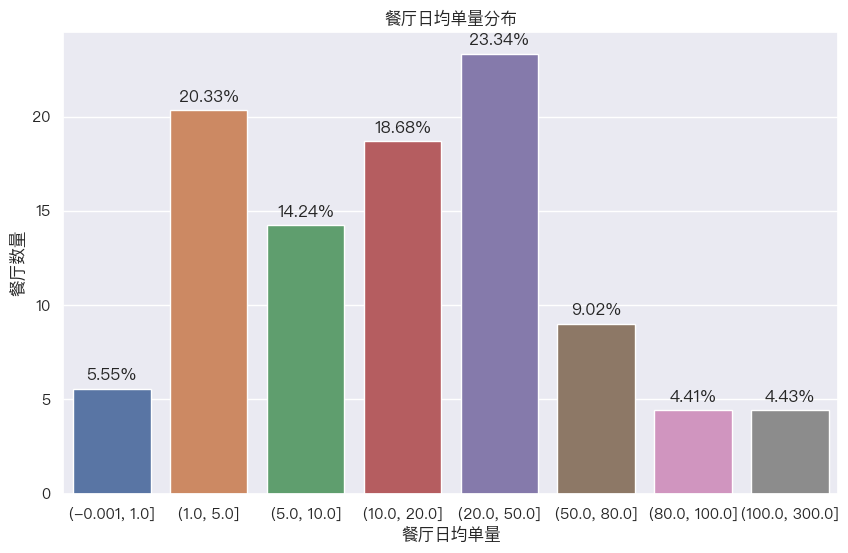

In [278]:
import pandas as pd
bins = [0, 1, 5, 10, 20, 50, 80, 100, 300] 
# 使用cut函数
r['日分桶'] = pd.cut(r['日订单数量'], bins=bins, right=True, include_lowest=True)
res2 = r.groupby('日分桶')['订单数量'].sum().reset_index()
res2['占比'] = round(100 * res2['订单数量'] / res2['订单数量'].sum(), 2)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='日分桶', y='占比', data=res2)
for p in ax.patches:
    height = p.get_height() 
    ax.annotate(f'{height}%',
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 4),  # 4 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom')
    
# 添加标题和标签
plt.title('餐厅日均单量分布')
plt.xlabel('餐厅日均单量')
plt.ylabel('餐厅数量')

# 显示图表
plt.show()

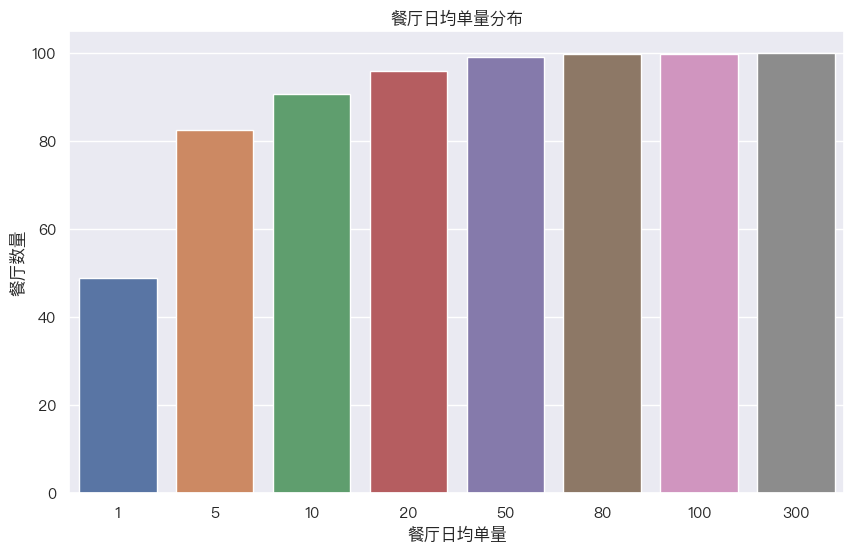

In [280]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个示例的Pandas DataFrame
# 假设有两个分类变量'Category'和对应的'Values'
data = {
    'Category': score_stats.columns,
    'Values': score_stats.iloc[0].values
}
df = pd.DataFrame(data)

# 使用Seaborn绘制柱状图
# 这里直接使用DataFrame的列名进行绘图
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Values', data=df)

# 添加标题和标签
plt.title('餐厅日均单量分布')
plt.xlabel('餐厅日均单量')
plt.ylabel('餐厅数量')

# 显示图表
plt.show()

In [282]:
score_stats.head()

,1,5,10,20,50,80,100,300
0,48.83,82.57,90.64,95.94,99.06,99.65,99.84,99.98


In [18]:
import pandas as pd

# 假设df是你的原始DataFrame
df = {  
    '订单编号': ['A001', 'A001', 'A002', 'A002', 'A002', 'A003', 'A003'],  
    '派单时间': ['2023-01-01 10:00', '2023-01-01 11:00', '2023-01-02 09:00', '2023-01-02 10:00', '2023-01-02 12:00', '2023-01-03 13:00', '2023-01-03 14:00'],  
    '分配类型': ['人工派单', '机器派单', '人工派单', '机器派单', '机器派单', '人工派单', '人工派单']  
}  

df = pd.DataFrame(data)  
# 假设df是您的DataFrame
# 对数据按订单编号和派单类型分组，计算每个分组的最大最小时间以及计数
grouped = df.groupby(['订单编号', '分配类型']).agg(
    最大派单时间=('派单时间', 'max'),
    最小派单时间=('派单时间', 'min'),
    派单数量=('派单时间', 'count')
).reset_index()

# 对分组结果进行透视，以便将人工和机器派单分开到不同的列
pivot_df = grouped.pivot_table(index='订单编号', 
                               columns='分配类型', 
                               values=['最大派单时间', '最小派单时间', '派单数量'],
                               aggfunc='first').fillna(0)

pivot_df.columns = ['_'.join(col) for col in pivot_df.columns]
pivot_df.rename(columns={'最大派单时间_人工派单': '人工派单最大时间',
                         '最大派单时间_机器派单': '机器派单最大时间',
                         '最小派单时间_人工派单': '人工派单最小时间',
                         '最小派单时间_机器派单': '机器派单最小时间',
                         '派单数量_人工派单': '人工派单次数',
                         '派单数量_机器派单': '机器派单次数'}, inplace=True)
pivot_df.reset_index(inplace=True)

# # 计算每个订单的最大和最小派单时间（不区分人工或机器）
order_times = df.groupby('订单编号')['派单时间'].agg(最大派单时间='max', 最小派单时间='min').reset_index()

# # 合并订单的最大最小时间与派单类型的统计信息
final_df = pd.merge(order_times, pivot_df, on='订单编号', how='left')
final_df['最终类型'] = final_df.apply(lambda row: '人工' if row['人工派单最大时间'] == row['最大派单时间'] else '机器', axis=1)

# 显示最终DataFrame
final_df.head()

,订单编号,最大派单时间,最小派单时间,人工派单最大时间,机器派单最大时间,人工派单最小时间,机器派单最小时间,人工派单次数,机器派单次数
0,A001,2023-01-01 11:00,2023-01-01 10:00,2023-01-01 10:00,2023-01-01 11:00,2023-01-01 10:00,2023-01-01 11:00,1.0,1.0
1,A002,2023-01-02 12:00,2023-01-02 09:00,2023-01-02 09:00,2023-01-02 12:00,2023-01-02 09:00,2023-01-02 10:00,1.0,2.0
2,A003,2023-01-03 14:00,2023-01-03 13:00,2023-01-03 14:00,0,2023-01-03 13:00,0,2.0,0.0


In [20]:
final_df['最终类型'] = final_df.apply(lambda row: '人工' if row['人工派单最大时间'] == row['最大派单时间'] else '机器', axis=1)
final_df.head()

,订单编号,最大派单时间,最小派单时间,人工派单最大时间,机器派单最大时间,人工派单最小时间,机器派单最小时间,人工派单次数,机器派单次数,最终类型
0,A001,2023-01-01 11:00,2023-01-01 10:00,2023-01-01 10:00,2023-01-01 11:00,2023-01-01 10:00,2023-01-01 11:00,1.0,1.0,机器
1,A002,2023-01-02 12:00,2023-01-02 09:00,2023-01-02 09:00,2023-01-02 12:00,2023-01-02 09:00,2023-01-02 10:00,1.0,2.0,机器
2,A003,2023-01-03 14:00,2023-01-03 13:00,2023-01-03 14:00,0,2023-01-03 13:00,0,2.0,0.0,人工


In [ ]:
final_df[final_df['订单编号'] == 1764942758041120768]